Environment ready. Python version: 2.0.2
Demo dataset generated: (50, 16)
Features shape: (50, 12) Labels shape: (50, 3)


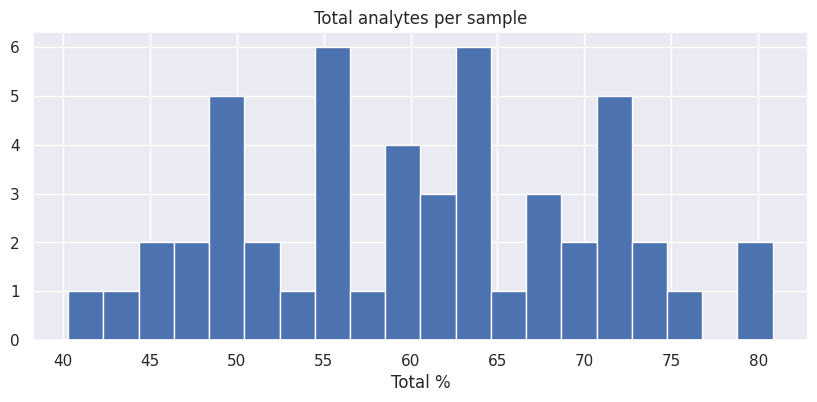

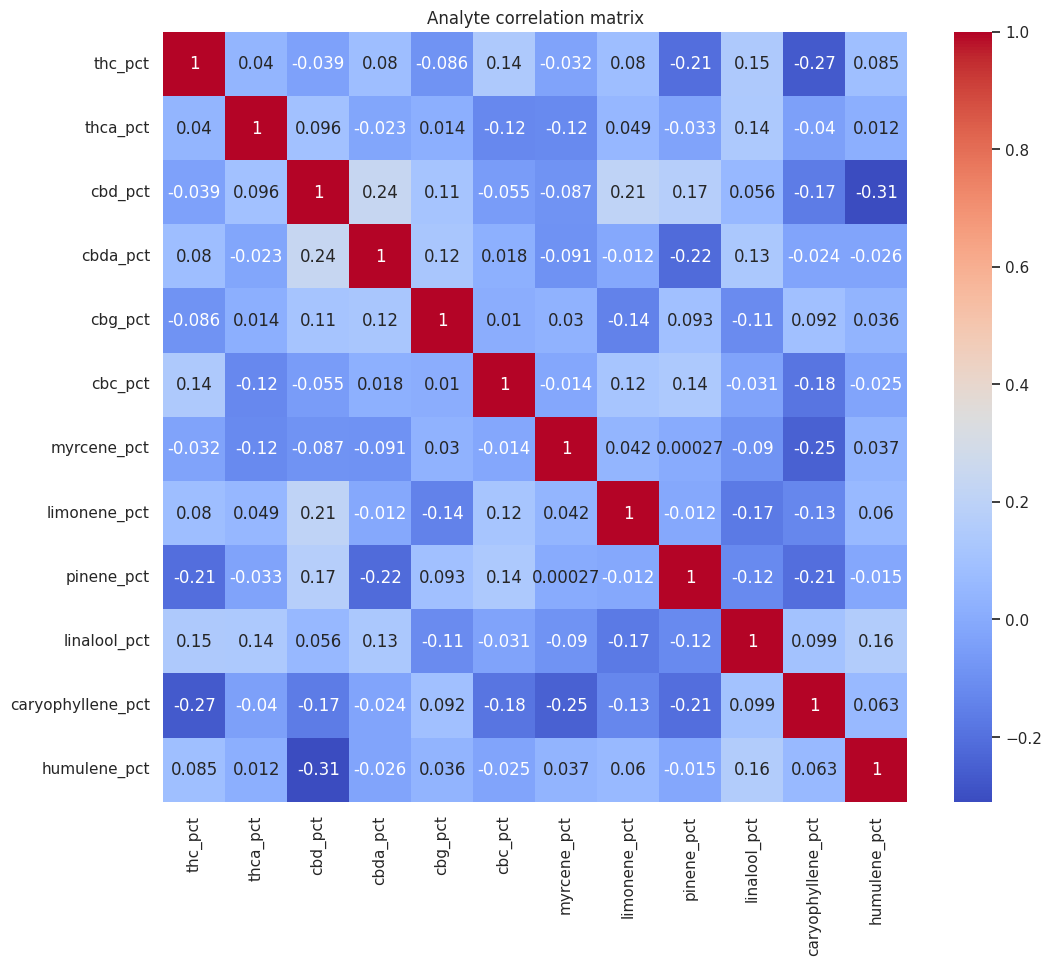


=== Training label: reduces_stress ===
RandomForest report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.67      0.80      0.73         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10


=== Training label: analgesic ===
RandomForest report:
               precision    recall  f1-score   support

           0       0.40      0.33      0.36         6
           1       0.20      0.25      0.22         4

    accuracy                           0.30        10
   macro avg       0.30      0.29      0.29        10
weighted avg       0.32      0.30      0.31        10


=== Training label: low_psychoactivity ===
RandomForest report:
               precision    recall  f1-score   support

           0       0.25      0.20      0.22         5
           1       0.33      0.40      0.36         

/tmp/ipython-input-1442156395.py:93: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample, show=True)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


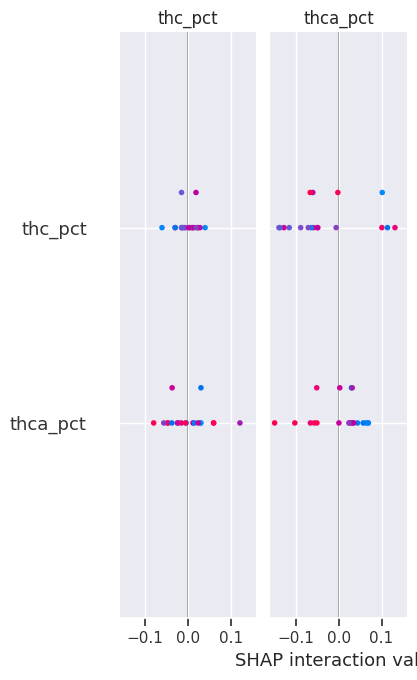


=== SHAP for label: analgesic ===


/tmp/ipython-input-1442156395.py:93: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample, show=True)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


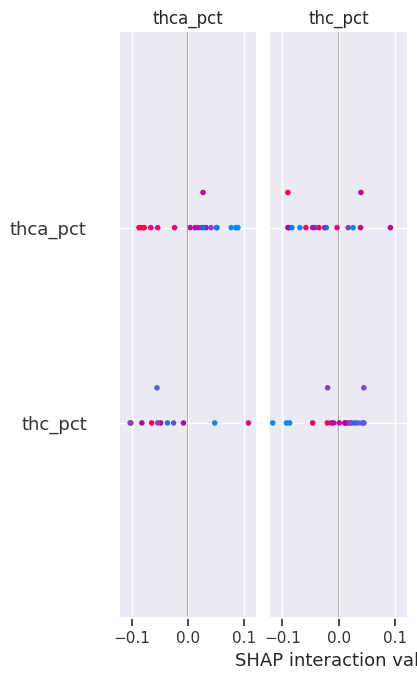


=== SHAP for label: low_psychoactivity ===


/tmp/ipython-input-1442156395.py:93: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample, show=True)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


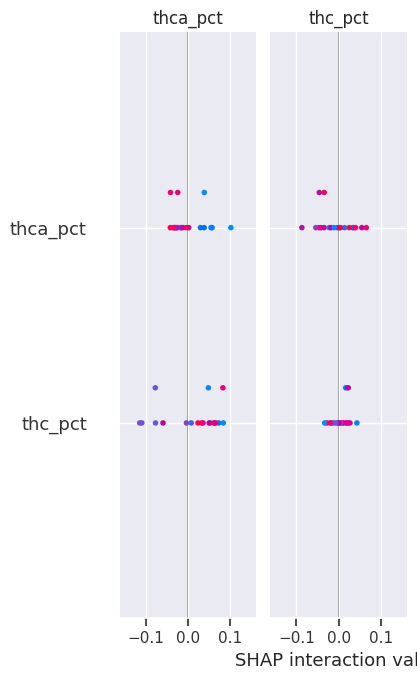

Epoch 20/100 Loss: 25.1286
Epoch 40/100 Loss: 25.1286
Epoch 60/100 Loss: 25.1286
Epoch 80/100 Loss: 25.1286
Epoch 100/100 Loss: 25.1286


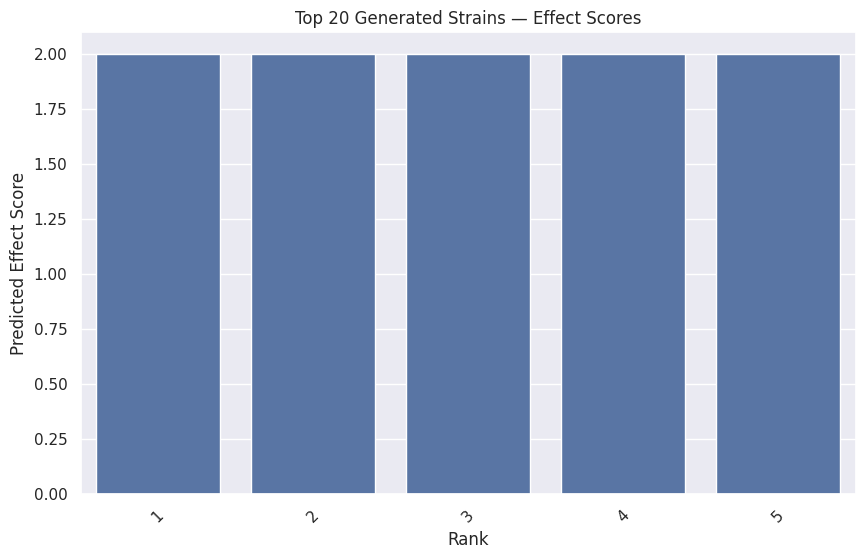

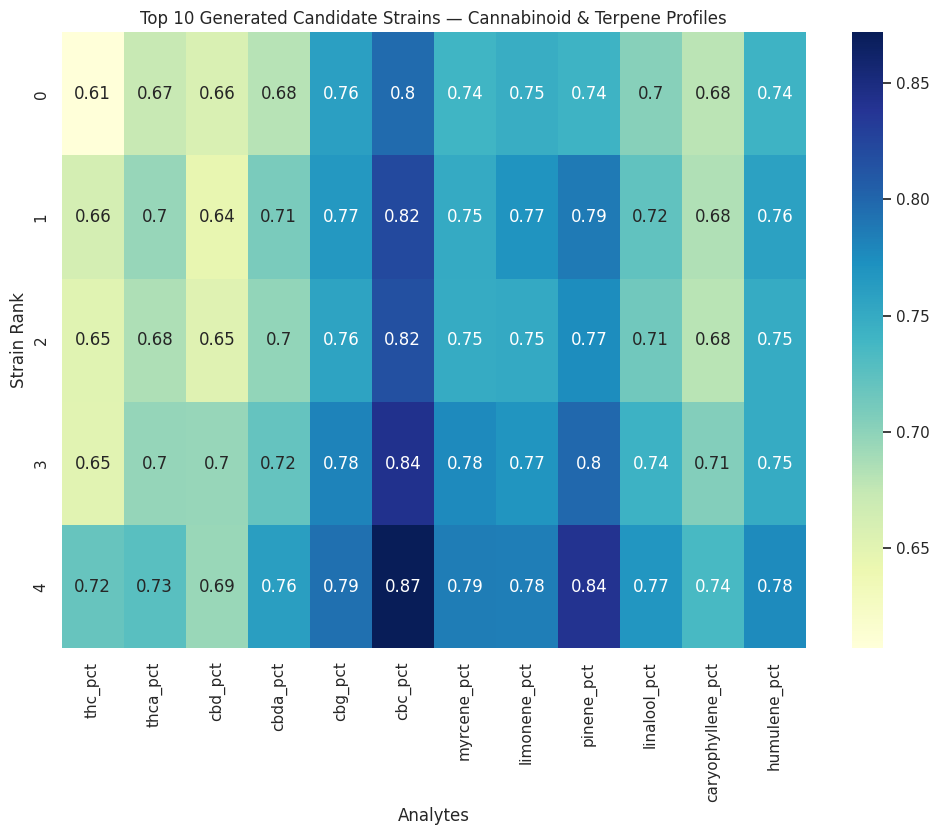

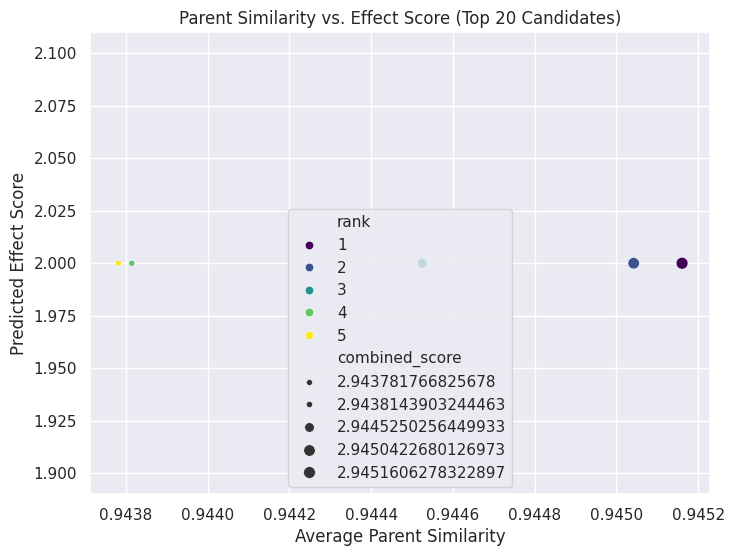

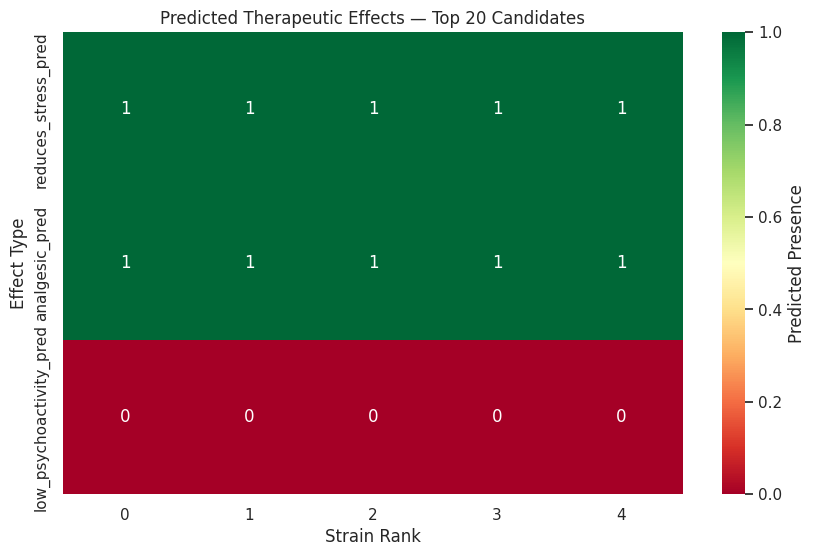

Final generated candidate strains saved to 'generated_candidate_strains_ranked_full.csv'


In [2]:
# =============================================
# 🌿 Pheno Hunting for Cannabis — Full Colab Prototype
# =============================================
# Purpose: Hybrid AI/ML tool for cannabis pheno-hunting
# - Supervised learning: Predict therapeutic effects from cannabinoid/terpene profiles
# - Generative modeling: Autoencoder prototype (GAN-ready infrastructure)
# Scope & Disclaimer: Research-only, Cannabis sativa L. (≤0.3% Δ9-THC)
# Use only legally obtained datasets; de-identify patient data
# =============================================

# -------------------------
# Environment setup
# -------------------------
!pip install -q pandas numpy scikit-learn matplotlib seaborn torch torchvision shap
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set()
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
import shap
print("Environment ready. Python version:", np.__version__)

# -------------------------
# Demo dataset / Upload
# -------------------------
DEMO_MODE = True  # Set False to upload your own CSV
if DEMO_MODE:
    np.random.seed(42)
    cannabinoids = ['thc_pct','thca_pct','cbd_pct','cbda_pct','cbg_pct','cbc_pct']
    terpenes = ['myrcene_pct','limonene_pct','pinene_pct','linalool_pct','caryophyllene_pct','humulene_pct']
    label_cols = ['reduces_stress','analgesic','low_psychoactivity']
    df = pd.DataFrame(np.random.rand(50,len(cannabinoids+terpenes))*10, columns=cannabinoids+terpenes)
    for lbl in label_cols:
        df[lbl] = np.random.randint(0,2,size=50)
    df['sample_id'] = [f"sample_{i}" for i in range(len(df))]
    print("Demo dataset generated:", df.shape)
else:
    from google.colab import files
    uploaded = files.upload()
    csv_name = list(uploaded.keys())[0]
    df = pd.read_csv(csv_name)
    cannabinoids = [c for c in df.columns if 'thc' in c or 'cbd' in c or 'cbg' in c or 'cbc' in c]
    terpenes = [c for c in df.columns if c not in cannabinoids + ['sample_id'] + label_cols]
    print("Uploaded dataset:", df.shape)

# -------------------------
# Preprocessing
# -------------------------
X = df[cannabinoids + terpenes].copy().fillna(0)
y = df[label_cols].copy()
print("Features shape:", X.shape, "Labels shape:", y.shape)

# -------------------------
# Exploratory Data Analysis
# -------------------------
plt.figure(figsize=(10,4))
X.sum(axis=1).hist(bins=20)
plt.title("Total analytes per sample")
plt.xlabel("Total %")
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Analyte correlation matrix")
plt.show()

# -------------------------
# Supervised model — RandomForest
# -------------------------
trained_models = {}
for lbl in label_cols:
    print("\n=== Training label:", lbl, "===")
    y_label = y[lbl].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y_label, stratify=y_label, test_size=0.2, random_state=42)
    rf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print("RandomForest report:\n", classification_report(y_test, y_pred))
    trained_models[lbl] = rf

# -------------------------
# SHAP feature importance
# -------------------------
for lbl, model in trained_models.items():
    print("\n=== SHAP for label:", lbl, "===")
    explainer = shap.TreeExplainer(model)
    sample = X.sample(n=min(20,len(X)), random_state=42)
    shap_values = explainer.shap_values(sample)
    shap.summary_plot(shap_values, sample, show=True)

# -------------------------
# Generative Autoencoder (GAN-ready infrastructure)
# -------------------------
input_dim = X.shape[1]
latent_dim = 6

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 12),
            nn.ReLU(),
            nn.Linear(12, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 12),
            nn.ReLU(),
            nn.Linear(12, input_dim),
            nn.Sigmoid()
        )
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

# GAN-ready placeholders
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 12),
            nn.ReLU(),
            nn.Linear(12, output_dim),
            nn.Sigmoid()
        )
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 12),
            nn.ReLU(),
            nn.Linear(12,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# Train autoencoder
ae = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=0.01)
X_tensor = torch.tensor(X.values, dtype=torch.float32)
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    X_hat, _ = ae(X_tensor)
    loss = criterion(X_hat, X_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1)%20==0:
        print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item():.4f}")

# Generate candidate strains
with torch.no_grad():
    z_sample = torch.rand(5, latent_dim)
    generated = ae.decoder(z_sample).numpy()
generated_df = pd.DataFrame(generated, columns=X.columns)

# -------------------------
# Parent strain tracking
# -------------------------
similarities = cosine_similarity(generated_df[X.columns], X)
top_parents = []
for sim_row in similarities:
    parent_indices = np.argsort(sim_row)[-2:][::-1]
    parent_names = df['sample_id'].iloc[parent_indices].tolist()
    top_parents.append(parent_names)
generated_df['parent_strains'] = top_parents

# -------------------------
# Predicted effect labeling
# -------------------------
for lbl, model in trained_models.items():
    generated_df[lbl+'_pred'] = model.predict(generated_df[X.columns])

# -------------------------
# Automated effect-based naming
# -------------------------
effect_mapping = { 'reduces_stress_pred':'Stress', 'analgesic_pred':'Analgesic', 'low_psychoactivity_pred':'LowPsycho' }
def generate_effect_name(row):
    effects = [label for col,label in effect_mapping.items() if row[col]==1]
    return "_".join(effects)+"_candidate" if effects else "Neutral_candidate"
generated_df['strain_name'] = generated_df.apply(generate_effect_name, axis=1)
def generate_full_name(row):
    parent_ids = "_".join([p.split("_")[1] for p in row['parent_strains']])
    return f"{row['strain_name']}_{parent_ids}"
generated_df['full_strain_name'] = generated_df.apply(generate_full_name, axis=1)

# -------------------------
# Scoring & Ranking
# -------------------------
generated_df['effect_score'] = generated_df[[c for c in generated_df.columns if c.endswith('_pred')]].sum(axis=1)
avg_parent_sim = [sim_row[np.argsort(sim_row)[-2:]].mean() for sim_row in similarities]
generated_df['parent_similarity'] = avg_parent_sim
generated_df['combined_score'] = generated_df['effect_score'] + generated_df['parent_similarity']
generated_df = generated_df.sort_values(by='combined_score', ascending=False).reset_index(drop=True)
generated_df['rank'] = generated_df.index + 1

# -------------------------
# Visualization
# -------------------------
# Bar plot: Effect score
plt.figure(figsize=(10,6))
sns.barplot(x='rank', y='effect_score', data=generated_df.head(20))
plt.title("Top 20 Generated Strains — Effect Scores")
plt.xlabel("Rank"); plt.ylabel("Predicted Effect Score"); plt.xticks(rotation=45)
plt.show()

# Heatmap: cannabinoid & terpene profiles top 10
plt.figure(figsize=(12,8))
sns.heatmap(generated_df.head(10)[X.columns], annot=True, cmap='YlGnBu')
plt.title("Top 10 Generated Candidate Strains — Cannabinoid & Terpene Profiles")
plt.xlabel("Analytes"); plt.ylabel("Strain Rank")
plt.show()

# Scatter: parent similarity vs effect score
plt.figure(figsize=(8,6))
sns.scatterplot(x='parent_similarity', y='effect_score', hue='rank', size='combined_score', data=generated_df.head(20), palette='viridis', legend='full')
plt.title("Parent Similarity vs. Effect Score (Top 20 Candidates)")
plt.xlabel("Average Parent Similarity"); plt.ylabel("Predicted Effect Score")
plt.show()

# Heatmap: predicted effects top 20
plt.figure(figsize=(10,6))
top20 = generated_df.head(20)
sns.heatmap(top20[[c+'_pred' for c in label_cols]].T, annot=True, cmap='RdYlGn', cbar_kws={'label':'Predicted Presence'})
plt.title("Predicted Therapeutic Effects — Top 20 Candidates")
plt.xlabel("Strain Rank"); plt.ylabel("Effect Type")
plt.show()

# -------------------------
# Save final CSV
# -------------------------
generated_df.to_csv("generated_candidate_strains_ranked_full.csv", index=False)
print("Final generated candidate strains saved to 'generated_candidate_strains_ranked_full.csv'")
